In [1]:
import numpy as np
import pandas as pd

import sklearn as skl
from sklearn import preprocessing as pp

from keras.models import Sequential
from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier #Deprecated
from scikeras.wrappers import KerasClassifier, KerasRegressor


import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib notebook

In [5]:
from robotClass_DQN_collisionAvoidance import learnEnv,robotEnv
from tensorflow import keras
from datetime import datetime
import math as m
import cv2, numpy

In [8]:
raw_data=pd.read_csv('ObsRecordUniformRandom_v5.csv')
world_data=pd.read_csv('characteristics_by_world.csv')
lidar_list = ["Lidar"+str(x) for x in range(0,32)]
state_list = ["goalDist","goalAng","forceAng","World"]
headers = lidar_list + state_list
raw_data.columns=headers
raw_data.head()

,Lidar0,Lidar1,Lidar2,Lidar3,Lidar4,Lidar5,Lidar6,Lidar7,Lidar8,Lidar9,...,Lidar26,Lidar27,Lidar28,Lidar29,Lidar30,Lidar31,goalDist,goalAng,forceAng,World
0,248.495046,172.992775,215.776400,247.349981,247.614431,247.443545,247.236193,214.247027,246.929451,246.411987,...,105.743861,118.035597,103.277421,120.227512,247.674366,248.495046,763.737268,-0.450601,-1.512448,0.0
1,248.055591,248.034650,248.003817,247.719787,247.193824,247.073649,246.931793,247.395986,246.740921,247.334310,...,150.590143,247.986754,248.343275,248.436833,248.255644,248.055591,421.719268,-0.426479,-2.876643,0.0
2,248.371780,248.332170,248.270438,247.121892,247.368452,247.189544,246.984724,247.384285,246.664636,247.196024,...,248.223223,118.111198,125.751782,140.816532,248.577542,248.371780,805.490985,-0.233516,2.230055,0.0
3,247.757427,247.745700,95.032361,105.181483,89.969389,107.332364,69.992179,64.372688,64.549098,66.482388,...,248.362178,247.769642,248.089265,223.077028,247.960515,247.757427,382.565520,0.659917,1.339265,0.0
4,247.597753,247.559832,247.531553,247.837751,227.680591,192.873422,142.248298,134.903531,132.476754,106.642140,...,248.400843,247.764990,248.041017,247.671804,247.833588,247.597753,733.064835,0.354814,2.115629,0.0


In [9]:
raw_data.describe()

,Lidar0,Lidar1,Lidar2,Lidar3,Lidar4,Lidar5,Lidar6,Lidar7,Lidar8,Lidar9,...,Lidar26,Lidar27,Lidar28,Lidar29,Lidar30,Lidar31,goalDist,goalAng,forceAng,World
count,52389.000000,52389.000000,52389.000000,52389.000000,52389.000000,52389.000000,52389.000000,52389.000000,52389.000000,52389.000000,...,52389.000000,52389.000000,52389.000000,52389.000000,52389.000000,52389.000000,52389.000000,52389.000000,52389.000000,52389.000000
mean,170.913113,166.665230,163.502865,162.105483,162.179855,163.410917,166.199310,170.241694,171.333878,169.968869,...,167.425213,165.916921,165.363866,166.431323,168.412597,170.913113,745.130702,0.034711,-0.071913,33.588196
std,93.005884,93.827391,94.199973,94.338024,94.426526,94.443780,94.250960,94.283147,94.421336,94.603673,...,93.202086,93.403635,93.280610,93.240014,93.258403,93.005884,219.865315,0.374101,1.320382,19.602248
min,0.014027,0.014027,0.014027,0.014027,0.014027,0.014027,0.014027,0.014027,0.014027,0.014027,...,0.014027,0.014027,0.014027,0.014027,0.014027,0.014027,300.698436,-0.926140,-3.141261,0.000000
25%,87.924720,80.084233,75.011023,72.761496,72.593535,74.693650,79.483604,84.598079,84.887081,84.061484,...,81.362179,80.367287,78.692490,80.819280,83.406666,87.924720,561.945357,-0.260297,-0.826878,17.000000
50%,235.869876,220.466978,208.020529,204.663116,204.899363,210.248629,222.119055,242.144660,246.489267,244.369471,...,220.267033,213.384691,210.579679,215.341789,223.558928,235.869876,742.430328,0.036452,-0.023488,34.000000
75%,247.988012,247.851745,247.704149,247.566404,247.430832,247.290380,247.171836,247.078607,246.986083,246.888773,...,248.148021,248.167532,248.144162,248.111715,248.059660,247.988012,932.655109,0.326298,0.475647,51.000000
max,248.501583,248.476743,248.417163,248.314852,248.181712,248.024775,247.846218,247.650563,247.498098,247.494356,...,248.872856,248.909537,248.885450,248.812112,248.678713,248.501583,1184.685116,0.977276,3.141278,67.000000


In [10]:
train_frac=2/3
ttr=(1-train_frac)/train_frac #train_test_ratio: 2 training worlds for each test world

world_ids=range(1,1+len(raw_data['World'].unique()))
test_world_ids=[w for w in world_ids if w%(ttr+1)==0 ]

In [11]:
min_max_scaler = pp.MinMaxScaler()
normalized_data=pd.DataFrame(min_max_scaler.fit_transform(raw_data.values),columns=headers)
normalized_data['World']=raw_data['World']


test_data=normalized_data[normalized_data['World'].isin(test_world_ids)]
train_data=normalized_data[~normalized_data['World'].isin(test_world_ids)]


targets_l=['forceAng']
features_l=headers.copy()
features_l.remove('forceAng')
features_l.remove('World')




In [12]:
test_data.describe()

,Lidar0,Lidar1,Lidar2,Lidar3,Lidar4,Lidar5,Lidar6,Lidar7,Lidar8,Lidar9,...,Lidar26,Lidar27,Lidar28,Lidar29,Lidar30,Lidar31,goalDist,goalAng,forceAng,World
count,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,...,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000
mean,0.696361,0.680173,0.666723,0.661100,0.659721,0.665544,0.678873,0.696395,0.700841,0.695756,...,0.680897,0.677173,0.673783,0.678021,0.687044,0.696361,0.501789,0.504197,0.486365,34.586018
std,0.372497,0.375536,0.377459,0.377650,0.377626,0.377874,0.376971,0.377075,0.378047,0.379393,...,0.371569,0.372809,0.373049,0.373373,0.373621,0.372497,0.248074,0.197250,0.207016,19.079016
min,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,...,0.000042,0.000042,0.000042,0.000043,0.000043,0.000043,0.000000,0.000000,0.000000,3.000000
25%,0.362616,0.333607,0.312134,0.304124,0.311357,0.320128,0.333377,0.369864,0.371180,0.352944,...,0.345267,0.334455,0.326079,0.333829,0.344836,0.362616,0.295873,0.350444,0.370254,18.000000
50%,0.996002,0.927421,0.874489,0.845106,0.841202,0.866138,0.914815,0.995565,0.996011,0.995464,...,0.905716,0.895720,0.877068,0.906125,0.955930,0.996002,0.496918,0.505031,0.495215,36.000000
75%,0.997985,0.997543,0.997181,0.997022,0.996997,0.997069,0.997330,0.997740,0.997960,0.997593,...,0.997139,0.997074,0.997108,0.997237,0.997581,0.997985,0.714492,0.656125,0.570671,51.000000
max,0.999997,0.999996,0.999959,1.000000,0.999975,1.000000,0.999972,1.000000,1.000000,1.000000,...,1.000000,0.999987,0.999959,0.999971,1.000000,0.999997,0.999305,0.999070,1.000000,66.000000


In [13]:
train_data.describe()

,Lidar0,Lidar1,Lidar2,Lidar3,Lidar4,Lidar5,Lidar6,Lidar7,Lidar8,Lidar9,...,Lidar26,Lidar27,Lidar28,Lidar29,Lidar30,Lidar31,goalDist,goalAng,forceAng,World
count,35439.000000,35439.000000,35439.000000,35439.000000,35439.000000,35439.000000,35439.000000,35439.000000,35439.000000,35439.000000,...,35439.000000,35439.000000,35439.000000,35439.000000,35439.000000,35439.000000,35439.000000,35439.000000,35439.000000,35439.000000
mean,0.683642,0.666213,0.654063,0.648834,0.650454,0.655618,0.666578,0.683111,0.688135,0.682429,...,0.668803,0.661478,0.659910,0.664515,0.672509,0.683642,0.503223,0.505093,0.489598,33.110951
std,0.375077,0.378552,0.380000,0.380964,0.381828,0.382163,0.381825,0.382399,0.383114,0.383565,...,0.375862,0.376345,0.375578,0.375351,0.375626,0.375077,0.249031,0.196204,0.211652,19.830151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000057,0.006553,0.000030,0.000000
25%,0.349056,0.314196,0.293979,0.291281,0.284530,0.292040,0.310889,0.330709,0.332173,0.330129,...,0.322976,0.313481,0.313851,0.323430,0.334126,0.349056,0.295272,0.349536,0.367387,16.000000
50%,0.929444,0.867111,0.825866,0.806677,0.816106,0.844155,0.886323,0.967841,0.995866,0.975086,...,0.869015,0.837573,0.828283,0.846152,0.878176,0.929444,0.501191,0.506177,0.496673,34.000000
75%,0.997909,0.997452,0.997112,0.996970,0.996966,0.997027,0.997252,0.997665,0.997916,0.997533,...,0.997064,0.996992,0.996978,0.997151,0.997471,0.997909,0.715033,0.658551,0.577624,50.000000
max,1.000000,1.000000,1.000000,0.999997,1.000000,0.999971,1.000000,0.999999,0.999998,0.999996,...,0.999995,1.000000,1.000000,1.000000,0.999985,1.000000,1.000000,1.000000,0.999819,67.000000


<IPython.core.display.Javascript object>


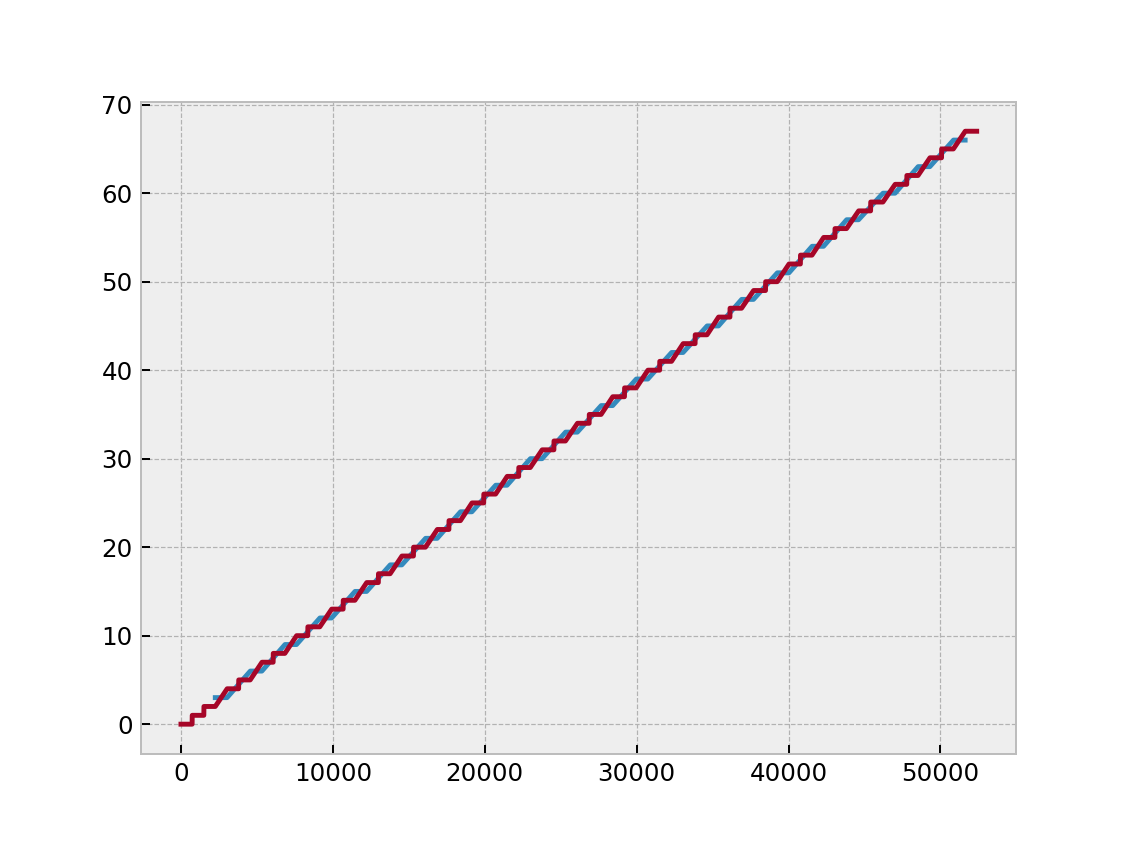

<AxesSubplot:>

In [14]:
plt.figure()
test_data['World'].plot()
train_data['World'].plot()


In [15]:
def createNN(layer_params=[],compile_params=[[],{'loss':'mean_squared_error', 'optimizer':'adam', 'metrics':['mse']}],model=Sequential):
    """Construct an arbitrary Keras layered model
        layer_params and compile params must have form list(iterable(list,dict)), 
            ex: [[[layer1_args],{layer1_kwarg1:val,layer1_kwarg2:val}],
                [[layer2_args],{layer2_kwarg1:val,layer2_kwarg2:val}]]
            While this may seem cumbersome, it provides full flexibility in creating the model object
    """
    model=model()
    for i in range(len(layer_params)):
        args=layer_params[i][0]
#         print(args)
        kwargs=layer_params[i][1]
#         print(kwargs)
        model.add(Dense(*args,**kwargs))
    model.compile(*compile_params[0],**compile_params[1])
    return model

def bulk_layers(n,layer_params):
    """Construct appropriate input dicts for bulk of the same layer"""
    return [layer_params for i in range(n)]

In [16]:
def get_driver_layers(HL_scale,activation):
    layers=[[[64], {'input_dim':len(features_l), 'activation':activation}],
[[64*HL_scale], {'activation':activation}],
[[64*HL_scale], {'activation':activation}],
[[1], {'activation':'linear'}]]
    return layers

In [18]:
layer_sizes=[2,32,64,128,256,512]
# activations=['relu','tanh']
# activations=['relu','sigmoid','tanh']
depths=[1,2,4,8,16,32]

batch_sizes=[32,64,128]
HL_scales=[1,2,3,4]
optimizers=['sgd','adam']
learning_rates=[0.1,0.01,0.001]



# def get_random_model(layer_sizes,activations,depth,input_dim,output_dim,compile_params=[[],{'loss':'mean_squared_error', 'optimizer':'adam', 'metrics':['mse']}]):
#     rng=np.random.default_rng()
#     lyrs=rng.choice(layer_sizes,size=depth)
#     activ=rng.choice(activations,size=depth+1)
#     layers=[[[lyrs[0]],{'input_dim':input_dim,'activation':activ[0]}]] #create input layer
#     for i in range(1,depth):
#         layers.append([[lyrs[i]],{'activation':activ[i]}])
#     layers.append([[1],{'activation':activ[-1]}]) #create output layer
    
#     return layers

def simulate_model(model,worlds):
    world_pf={}
    pf_sum=0
    for w in worlds:
        pas=np.random.choice([1,0]) ###Put real simulator call here
        world_pf[w]=pas
        pf_sum+=pas
    return pf_sum,world_pf

In [20]:
results={}
score_dict={}

epochs=1
for b_sz in batch_sizes:
    for hl_scale in HL_scales:
        for lr in learning_rates:
            for opt in optimizers:
                test_params=(b_sz,hl_scale,lr,opt)
                print(test_params)
                layers=get_driver_layers(hl_scale,'relu')
                compile_params=[[],{'loss':'mean_squared_error', 'optimizer':opt,'learning_rate':lr, 'metrics':['mse']}]
                model=createNN(layer_params=layers,compile_params=compile_params)
                model.fit(train_data[features_l],train_data[targets_l],epochs=epochs,batch_size=b_sz)
                
                _,trn_score=model.evaluate(train_data[features_l],train_data[targets_l])

                _,test_score=model.evaluate(test_data[features_l],test_data[targets_l])

                pf_sum,pf_by_world=simulate_model(model,test_world_ids)

                results[test_params]={'layers':layers,'model':model,
                                      'training score':trn_score,'test score':test_score,'pf_score':pf_sum,'pf_by_world':pf_by_world}
                print(score)
                score_dict[test_params]=[trn_score,test_score,pf_sum]

(64, 3, 'relu')
530/530 [==============================] - 1s 1ms/step - loss: 0.0127 - mse: 0.0127
0.012671316042542458
(64, 3, 'tanh')
530/530 [==============================] - 1s 1ms/step - loss: 0.0191 - mse: 0.0191
0.019130676984786987
(64, 4, 'relu')
530/530 [==============================] - 1s 1ms/step - loss: 0.0124 - mse: 0.0124
0.012439655140042305
(64, 4, 'tanh')
530/530 [==============================] - 1s 1ms/step - loss: 0.0165 - mse: 0.0165
0.016456371173262596
(128, 3, 'relu')
530/530 [==============================] - 1s 1ms/step - loss: 0.0135 - mse: 0.0135
0.013450591824948788
(128, 3, 'tanh')
530/530 [==============================] - 1s 1ms/step - loss: 0.0187 - mse: 0.0187
0.01868937537074089
(128, 4, 'relu')
530/530 [==============================] - 1s 1ms/step - loss: 0.0128 - mse: 0.0128
0.01282438077032566
(128, 4, 'tanh')
530/530 [==============================] - 1s 1ms/step - loss: 0.0174 - mse: 0.0174
0.017351685091853142


In [21]:
results

{(64,
  3,
  'relu'): {'layers': [[[64], {'input_dim': 34, 'activation': 'relu'}],
   [[192], {'activation': 'relu'}],
   [[192], {'activation': 'relu'}],
   [[1],
    {'activation': 'linear'}]], 'model': <keras.engine.sequential.Sequential at 0x27e0f57d9d0>, 'score': 0.012671316042542458, 'pf_score': 7, 'pf_by_world': {3: 1,
   6: 0,
   9: 1,
   12: 0,
   15: 0,
   18: 0,
   21: 0,
   24: 0,
   27: 0,
   30: 0,
   33: 0,
   36: 1,
   39: 0,
   42: 1,
   45: 0,
   48: 1,
   51: 0,
   54: 0,
   57: 0,
   60: 1,
   63: 0,
   66: 1}},
 (64,
  3,
  'tanh'): {'layers': [[[64], {'input_dim': 34, 'activation': 'tanh'}],
   [[192], {'activation': 'tanh'}],
   [[192], {'activation': 'tanh'}],
   [[1],
    {'activation': 'linear'}]], 'model': <keras.engine.sequential.Sequential at 0x27e11282340>, 'score': 0.019130676984786987, 'pf_score': 9, 'pf_by_world': {3: 0,
   6: 0,
   9: 0,
   12: 1,
   15: 0,
   18: 0,
   21: 1,
   24: 1,
   27: 1,
   30: 0,
   33: 1,
   36: 1,
   39: 0,
   42: 0,
   45:

In [38]:
idx=score_dict.keys()
vals=[score_dict[i] for i in idx]
Score_df=pd.DataFrame(vals,index=idx,columns=['Training Score','Testing Score','Pass Count'])
Score_df.index.names=['Batch Size','HL_Scaler','Activation']

In [39]:
Score_df

Score  Pass Count
Batch Size HL_Scaler Activation                      
64         3         relu        0.012671           7
                     tanh        0.019131           9
           4         relu        0.012440           9
                     tanh        0.016456          10
128        3         relu        0.013451          13
                     tanh        0.018689          14
           4         relu        0.012824          13
                     tanh        0.017352          14

In [43]:
Score_df.loc[:,:,'relu']

Score  Pass Count
Batch Size HL_Scaler                      
64         3          0.012671           7
           4          0.012440           9
128        3          0.013451          13
           4          0.012824          13